# 03 Decision Simulation

We compare two decision policies:

1) Baseline heuristic:
Order yesterday’s demand plus a fixed buffer.

2) Forecast-informed:
Order forecast demand plus a dynamic buffer.

We measure:
- stockout rate
- average buffer
- simple cost trade-off (holding vs stockout penalty)

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

DATA = Path("../data/processed/test_forecasts.parquet")

OUT_FIG = Path("../outputs/figures")
OUT_TAB = Path("../outputs/tables")
OUT_FIG.mkdir(parents=True, exist_ok=True)
OUT_TAB.mkdir(parents=True, exist_ok=True)

df = pd.read_parquet(DATA).sort_values("date").reset_index(drop=True)

# Policies
STATIC_BUFFER = 20
df["buffer_static"] = STATIC_BUFFER
df["order_static"] = df["demand"].shift(1) + df["buffer_static"]

df["buffer_dynamic"] = np.maximum(10, 0.2 * df["forecast"])
df["order_dynamic"] = df["forecast"] + df["buffer_dynamic"]

# Drop first row where baseline has no yesterday
df = df.dropna(subset=["order_static"]).copy()

# Outcomes
df["stockout_static"] = df["order_static"] < df["demand"]
df["stockout_dynamic"] = df["order_dynamic"] < df["demand"]

# Simple cost model (optional but strong signal)
HOLDING_COST_PER_UNIT = 1.0
STOCKOUT_COST_PER_UNIT = 8.0

df["short_static"] = np.maximum(0, df["demand"] - df["order_static"])
df["short_dynamic"] = np.maximum(0, df["demand"] - df["order_dynamic"])

df["hold_static"] = np.maximum(0, df["order_static"] - df["demand"])
df["hold_dynamic"] = np.maximum(0, df["order_dynamic"] - df["demand"])

df["cost_static"] = HOLDING_COST_PER_UNIT * df["hold_static"] + STOCKOUT_COST_PER_UNIT * df["short_static"]
df["cost_dynamic"] = HOLDING_COST_PER_UNIT * df["hold_dynamic"] + STOCKOUT_COST_PER_UNIT * df["short_dynamic"]

summary = pd.DataFrame({
    "policy": ["static_last_observed", "forecast_informed"],
    "stockout_rate": [df["stockout_static"].mean(), df["stockout_dynamic"].mean()],
    "avg_buffer": [df["buffer_static"].mean(), df["buffer_dynamic"].mean()],
    "avg_total_cost": [df["cost_static"].mean(), df["cost_dynamic"].mean()],
    "avg_holding_units": [df["hold_static"].mean(), df["hold_dynamic"].mean()],
    "avg_short_units": [df["short_static"].mean(), df["short_dynamic"].mean()],
}).round(4)

summary.to_csv(OUT_TAB / "before_after_comparison.csv", index=False)
summary


,policy,stockout_rate,avg_buffer,avg_total_cost,avg_holding_units,avg_short_units
0,static_last_observed,0.0625,20.000,23.6623,20.3519,0.4138
1,forecast_informed,0.0208,24.777,24.1366,23.6489,0.0610


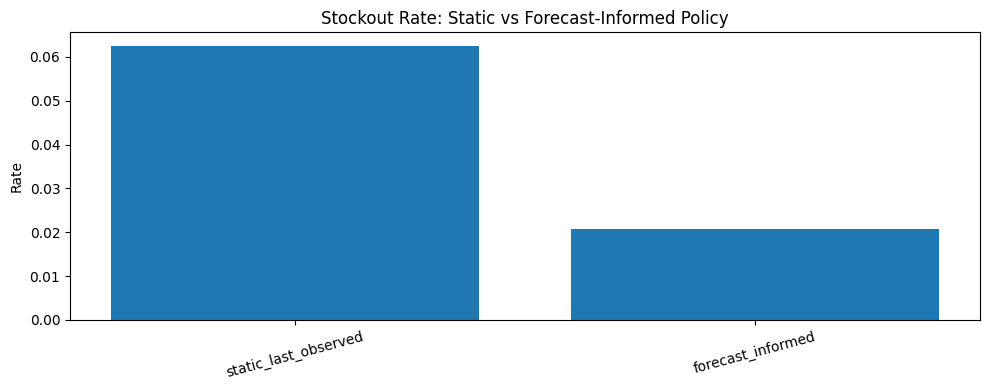

In [5]:
plt.figure(figsize=(10,4))
plt.bar(summary["policy"], summary["stockout_rate"])
plt.title("Stockout Rate: Static vs Forecast-Informed Policy")
plt.ylabel("Rate")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(OUT_FIG / "decision_impact.png", dpi=200, bbox_inches="tight")
plt.show()
